# Multilayer Perceptron

In the previous chapters, we showed how you could implement multiclass logistic regression (also called softmax regression)
for classifying images of clothing into the 10 possible categories.
To get there, we had to learn how to wrangle data,
coerce our outputs into a valid probability distribution (via `softmax`),
how to apply an appropriate loss function,
and how to optimize over our parameters.
Now that we’ve covered these preliminaries,
we are free to focus our attention on
the more exciting enterprise of designing powerful models
using deep neural networks.

## Hidden Layers

Recall that for linear regression and softmax regression,
we mapped our inputs directly to our outputs
via a single linear transformation:

$$
\hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})
$$

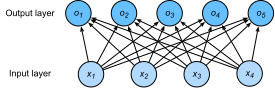

In [1]:
from IPython.display import SVG
SVG(filename='../img/singlelayer.svg')

If our labels really were related to our input data
by an approximately linear function, then this approach would be perfect.
But linearity is a *strong assumption*.
Linearity implies that for whatever target value we are trying to predict,
increasing the value of each of our inputs
should either drive the value of the output up or drive it down,
irrespective of the value of the other inputs.

Sometimes this makes sense!
Say we are trying to predict whether an individual
will or will not repay a loan.
We might reasonably imagine that all else being equal,
an applicant with a higher income
would be more likely to repay than one with a lower income.
In these cases, linear models might perform well,
and they might even be hard to beat.

But what about classifying images in FashionMNIST?
Should increasing the intensity of the pixel at location (13,17)
always increase the likelihood that the image depicts a pocketbook?
That seems ridiculous because we all know
that you cannot make sense out of an image
without accounting for the interactions among pixels.



### From one to many

As another case, consider trying to classify images
based on whether they depict *cats* or *dogs* given black-and-white images.

If we use a linear model, we'd basically be saying that
for each pixel, increasing its value (making it more white)
must always increase the probability that the image depicts a dog
or must always increase the probability that the image depicts a cat.
We would be making the absurd assumption that the only requirement
for differentiating cats vs. dogs is to assess how bright they are.
That approach is doomed to fail in a work
that contains both black dogs and black cats,
and both white dogs and white cats.

Teasing out what is depicted in an image generally requires
allowing more complex relationships between our inputs and outputs.
Thus we need <font color=red>models capable of discovering patterns
that might be characterized by interactions among the many features.</font>
We can over come these limitations of linear models
and handle a more general class of functions
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many layers of neurons on top of each other.
Each layer feeds into the layer above it, until we generate an output.
This architecture is commonly called a *multilayer perceptron*,
often abbreviated as *MLP*.
The neural network diagram for an MLP looks like this:

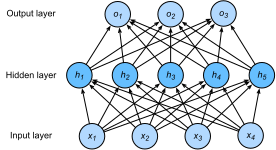

In [2]:
SVG(filename='../img/mlp.svg')

The multilayer perceptron above has 4 inputs and 3 outputs,
and the hidden layer in the middle contains 5 hidden units.
Since the input layer does not involve any calculations,
building this network would consist of
implementing 2 layers of computation.
The neurons in the input layer are fully connected
to the inputs in the hidden layer.
Likewise, the neurons in the hidden layer
are fully connected to the neurons in the output layer.


### From linear to nonlinear

We can write out the calculations that define this one-hidden-layer MLP in mathematical notation as follows:
$$
\begin{aligned}
    \mathbf{h} & = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

By adding another layer, we have added two new sets of parameters,
but what have we gained in exchange?
In the model defined above, we do not achieve anything for our troubles!

That's because our hidden units are just a linear function of the inputs
and the outputs (pre-softmax) are just a linear function of the hidden units.
A linear function of a linear function is itself a linear function.
That means that for any values of the weights,
we could just collapse out the hidden layer
yielding an equivalent single-layer model using
$\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$.

$$\mathbf{o} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 = \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) = \mathbf{W} \mathbf{x} + \mathbf{b}$$

In order to get a benefit from multilayer architectures,
we need another key ingredient—a nonlinearity $\sigma$ to be applied to each of the hidden units after each layer's linear transformation.
<font color=red>The most popular choice for the nonlinearity these days is the rectified linear unit (ReLU) $\mathrm{max}(x,0)$. </font>
After incorporating these non-linearities
it becomes impossible to merge layers.

$$
\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

Clearly, we could continue stacking such hidden layers,
e.g. $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$
and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$
on top of each other to obtain a true multilayer perceptron.

Multilayer perceptrons can account for complex interactions in the inputs
because the hidden neurons depend on the values of each of the inputs.
It’s easy to design a hidden node that does arbitrary computation,
such as, for instance, logical operations on its inputs.
Moreover, for certain choices of the activation function
it’s widely known that multilayer perceptrons are universal approximators.
That means that even for a single-hidden-layer neural network,
with enough nodes, and the right set of weights,
we can model any function at all!
*Actually learning that function is the hard part.*

Moreover, just because a single-layer network *can* learn any function
doesn't mean that you should try to solve all of your problems with single-layer networks.
It turns out that we can approximate many functions
much more compactly if we use deeper (vs wider) neural networks.
We’ll get more into the math in a subsequent chapter,
but for now let’s actually build an MLP.
In this example, we’ll implement a multilayer perceptron
with two hidden layers and one output layer.

### Vectorization and mini-batch

As before, by the matrix $\mathbf{X}$, we denote a mini-batch of inputs.
The calculations to produce outputs from an MLP with two hidden layers
can thus be expressed:

$$
\begin{aligned}
    \mathbf{H}_1 & = \sigma(\mathbf{W}_1 \mathbf{X} + \mathbf{b}_1) \\
    \mathbf{H}_2 & = \sigma(\mathbf{W}_2 \mathbf{H}_1 + \mathbf{b}_2) \\
    \mathbf{O} & = \mathrm{softmax}(\mathbf{W}_3 \mathbf{H}_2 + \mathbf{b}_3)
\end{aligned}
$$

With some abuse of notation, we define the nonlinearity $\sigma$
to apply to its inputs on a row-wise fashion, i.e. one observation at a time.
Note that we are also using the notation for *softmax* in the same way to denote a row-wise operation.
Often, as in this chapter, the activation functions that we apply to hidden layers are not merely row-wise, but component wise.
That means that after computing the linear portion of the layer,
we can calculate each nodes activation without looking at the values taken by the other hidden units.
This is true for most activation functions
(the batch normalization operation will be introduced in :numref:`chapter_batch_norm` is a notable exception to that rule).

## Activation Functions

Because they are so fundamental to deep learning, before going further,
let's take a brief look at some common activation functions.

### ReLU Function

As stated above, the most popular choice,
due to its simplicity of implementation
and its efficacy in training is the rectified linear unit (ReLU).
ReLUs provide a very simple nonlinear transformation.
Given the element $z$, the function is defined
as the maximum of that element and 0.

$$\mathrm{ReLU}(z) = \max(z, 0).$$

It can be understood that the ReLU function retains only positive elements and discards negative elements (setting those nodes to 0).
To get a better idea of what it looks like, we can plot it.
For convenience, we define a plotting function `xyplot`
to take care of the groundwork.

In [3]:
import sys
sys.path.insert(0, '..')

import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
def xyplot(x_vals,y_vals,name):
    x_vals=x_vals.detach().numpy() # we can't directly use var.numpy() because varibles might 
    y_vals=y_vals.detach().numpy() # already required grad.,thus using var.detach().numpy() 
    plt.plot(x_vals,y_vals) 
    plt.xlabel('x')
    plt.ylabel(name+'(x)')

Since relu is commomly used as activation function, PyTorch supports
the `relu` function as a basic native operator.
As you can see, the activation function is piece-wise linear.


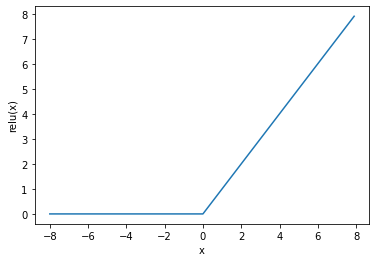

In [28]:
x=Variable(torch.arange(-8.0,8.0,0.1,dtype=torch.float32).reshape(-1,1),requires_grad=True)
y=torch.nn.functional.relu(x)
xyplot(x,y,'relu')

When the input is negative, the derivative of ReLU function is 0
and when the input is positive, the derivative of ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to  0.
In these cases, we go with the left-hand-side (LHS) derivative
and say that the derivative is 0 when the input is 0.
We can get away with this because the input may never actually be zero.
There's an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here.
See the derivative of the ReLU function plotted below.

When we use .backward(), by default it is .backward(torch.Tensor([1])).This is useful when we are dealing with single scalar input.But here we are dealing with a vector input so we have to use this snippet.

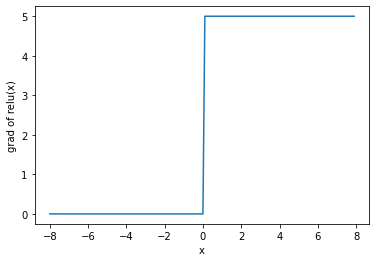

In [33]:
y.backward(torch.ones_like(y), retain_graph=True) # vector cannot call backward directly, need tricks
xyplot(x,x.grad,"grad of relu")
# if retain_graph is true, the backward grad will be added to the existing ones
# n times you run the code, the grad will become n

Note that there are many variants to the ReLU function, such as the parameterized ReLU (pReLU) of [He et al., 2015](https://arxiv.org/abs/1502.01852). This variation adds a linear term to the ReLU, so some information still gets through, even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x)$$

<font color=red>The reason for using the ReLU is that its derivatives are particularly well behaved - either they vanish or they just let the argument through. This makes optimization better behaved and it reduces the issue of the vanishing gradient problem</font> (more on this later).

### Sigmoid Function

The sigmoid function transforms its inputs which take values in $\mathbb{R}$ to the interval $(0,1)$.
For that reason, the sigmoid is often called a *squashing* function:
it squashes any input in the range (-inf, inf)
to some value in the range (0,1).

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *don't fire*.
Thus the pioneers of this field, going all the way back to McCulloch and Pitts in the 1940s, were focused on thresholding units.
A thresholding function takes either value $0$
(if the input is below the threshold)
or value $1$ (if the input exceeds the threshold)


When attention shifted to gradient based learning, <font color=red>
the sigmoid function was a natural choice
because it is a smooth, differentiable approximation to a thresholding unit.</font>
**Sigmoids are still common as activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems
(you can think of the sigmoid as a special case of the softmax)
but the sigmoid has mostly been replaced by the simpler and easier to train ReLU for most use in hidden layers.**
In the "Recurrent Neural Network" chapter, we will describe
how sigmoid units can be used to control
the flow of information in a neural network
thanks to its capacity to transform the value range between 0 and 1.

See the sigmoid function plotted below.
When the input is close to 0, the sigmoid function
approaches a linear transformation.


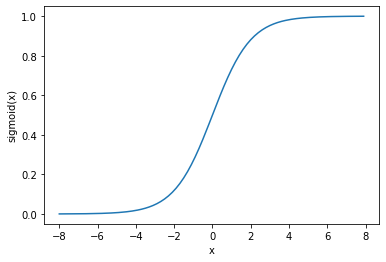

In [23]:
x=Variable(torch.arange(-8.0,8.0,0.1,dtype=torch.float32).reshape(-1,1),requires_grad=True)
y=torch.sigmoid(x)
xyplot(x,y,'sigmoid')

The derivative of sigmoid function is given by the following equation:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


The derivative of sigmoid function is plotted below.
Note that when the input is 0, the derivative of the sigmoid function
reaches a maximum of 0.25. As the input diverges from 0 in either direction, the derivative approaches 0.


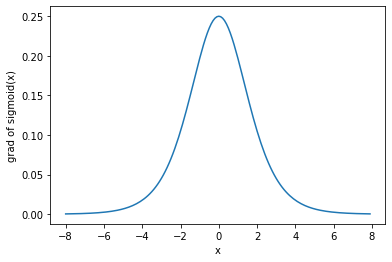

In [24]:
y.backward(torch.ones_like(y),retain_graph=True)
xyplot(x,x.grad,'grad of sigmoid')

### Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent)
function also squashes its inputs,
transforms them into elements on the interval between -1 and 1:

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function blow. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


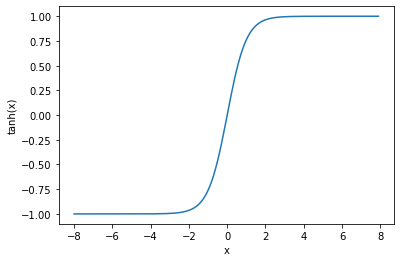

In [25]:
x=Variable(torch.arange(-8.0,8.0,0.1,dtype=torch.float32).reshape(-1,1),requires_grad=True)
y=torch.tanh(x)
xyplot(x,y,"tanh")

The derivative of the Tanh function is:

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$

The derivative of tanh function is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as the input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

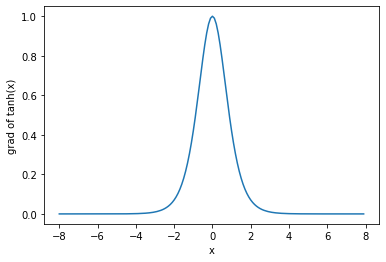

In [26]:
y.backward(torch.ones_like(y),retain_graph=True)
xyplot(x,x.grad,"grad of tanh")

In summary, we now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge now already
puts you in command of the state of the art in deep learning, circa 1990.
In fact, you have an advantage over anyone working the 1990s,
because you can leverage powerful open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, getting these nets training
required researchers to code up thousands of lines of C and Fortran.

## Summary

* The multilayer perceptron adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.
* <font color=red> Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.</font>


## Exercises

1. Compute the derivative of the tanh and the pReLU activation function.
1. Show that a multilayer perceptron using only ReLU (or pReLU) constructs a continuous piecewise linear function.
1. Show that $\mathrm{tanh}(x) + 1 = 2 \mathrm{sigmoid}(2x)$.
1. Assume we have a multilayer perceptron *without* nonlinearities between the layers. In particular, assume that we have $d$ input dimensions, $d$ output dimensions and that one of the layers had only $d/2$ dimensions. Show that this network is less expressive (powerful) than a single layer perceptron.
1. Assume that we have a nonlinearity that applies to one minibatch at a time. What kinds of problems to you expect this to cause?
